## this notebook contains 4 distinct approaches:
- a unique approach to use N binary classifiers each outputting a confidence score.
- approach to use feature engineering based on observations and this [notebook](https://www.kaggle.com/code/vishnupriyagarige/optimal-fertilizers-prediction-xgb)
    - append a few extra features.
    - measure performance with and without certain features.
- creating softer targets based on observations and special EDA. - combine classes; create new unique targets
    - scratch this now ; could not find any case for imbalanced FP or FN for any class w.r.t other classes; no trends between numerical values either.
- mixing training data from original source to help boost training accuracy.

In [1]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, OrdinalEncoder
from xgboost import XGBClassifier

In [2]:
import pandas as pd
import numpy as np

sample_train_df = pd.read_csv("data/s5e6/train.csv")
numerical_features = [x for x in sample_train_df.describe().columns if x != "id"]
categorical_features = [x for x in sample_train_df.columns if x not in numerical_features and x != "id"]
numerical_features, categorical_features

(['Temparature',
  'Humidity',
  'Moisture',
  'Nitrogen',
  'Potassium',
  'Phosphorous'],
 ['Soil Type', 'Crop Type', 'Fertilizer Name'])

In [3]:
import glob
files = glob.glob("data/s5e6/*.csv")
files

['data/s5e6/test.csv',
 'data/s5e6/previous_competition.csv',
 'data/s5e6/train.csv',
 'data/s5e6/sample_submission.csv']

In [5]:
test_file = files[0]
train_file = files[2]
test_df = pd.read_csv(test_file).drop(columns = ["id"])
train_df = pd.read_csv(train_file).drop(columns = ["id"])
test_df.columns, train_df.columns

(Index(['Temparature', 'Humidity', 'Moisture', 'Soil Type', 'Crop Type',
        'Nitrogen', 'Potassium', 'Phosphorous'],
       dtype='object'),
 Index(['Temparature', 'Humidity', 'Moisture', 'Soil Type', 'Crop Type',
        'Nitrogen', 'Potassium', 'Phosphorous', 'Fertilizer Name'],
       dtype='object'))

In [6]:
## one-hot encoding of the categorical features.
oe = OrdinalEncoder()
train_df[categorical_features[:-1]] = oe.fit_transform(train_df[categorical_features[:-1]])
test_df[categorical_features[:-1]] = oe.transform(test_df[categorical_features[:-1]])

In [7]:
## transform the label as well.
target_feature = categorical_features[-1]
le = LabelEncoder()
train_df[target_feature] = le.fit_transform(train_df[target_feature])
train_df.head()

,Temparature,Humidity,Moisture,Soil Type,Crop Type,Nitrogen,Potassium,Phosphorous,Fertilizer Name
0,37,70,36,1.0,8.0,36,4,5,4
1,27,69,65,4.0,4.0,30,6,18,4
2,29,63,32,4.0,4.0,24,12,16,2
3,35,62,54,4.0,0.0,39,12,4,0
4,35,58,43,3.0,6.0,37,2,16,5


In [17]:
full_y, full_x = train_df[target_feature], train_df.drop(columns = [target_feature])
train_x, test_x, train_y, test_y = train_test_split(full_x, full_y, test_size = 0.2, random_state = 42, stratify = full_y)

In [27]:
def create_balanced_splits():
    train_splits = {}
    for t in range(len(le.classes_)):
        pos_idx = train_y[train_y == t].index
        pos_samples = train_x.loc[pos_idx]
        pos_labels = train_y.loc[pos_idx]

        n_pos = len(pos_idx)
        neg_idx = train_y[train_y != t].index
        neg_x = train_x.loc[neg_idx]
        neg_y = train_y.loc[neg_idx]
        
        neg_x_sampled, _, neg_y_sampled, _ = train_test_split(neg_x, neg_y, train_size = n_pos, stratify = neg_y, random_state = 42)
        binary_x = pd.concat([pos_samples, neg_x_sampled])
        binary_y = pd.Series([1] * n_pos + [0] * n_pos, index = binary_x.index)

        ## shuffle.
        binary_x = binary_x.sample(frac = 1, random_state = 42)
        binary_y = binary_y.loc[binary_x.index]

        train_splits[t] = (binary_x, binary_y)
    
    return train_splits

In [28]:
btrain_splits = create_balanced_splits()

In [ ]:
models = {}
for t_x, (btx, bty) in btrain_splits.items():
    model_tx = XGBClassifier(
        objective="binary:logistic",
        n_estimators=1000,
        learning_rate=0.045,
        max_depth=5,
        colsample_bytree=0.6,
        colsample_bylevel=0.8,
        subsample=0.8,
        use_label_encoder=False,  # Optional, to suppress deprecation warnings
        eval_metric="logloss"     # Optional but recommended for binary classification
    )

    model_tx.fit(btx, bty)
    models[t_x] = model_tx



/Users/abhishekmish/Documents/repos/kaggle_playground/.venv/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [17:08:50] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/abhishekmish/Documents/repos/kaggle_playground/.venv/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [17:08:53] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/abhishekmish/Documents/repos/kaggle_playground/.venv/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [17:08:55] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/abhishekmish/Documents/repos/kaggle_playground/.venv/lib/python3.12/site-packages/xgboost/training.

In [32]:
models[0].predict_proba(test_x)

array([[0.51839674, 0.48160326],
       [0.35552114, 0.64447886],
       [0.5000159 , 0.4999841 ],
       ...,
       [0.35835075, 0.64164925],
       [0.49628627, 0.5037137 ],
       [0.4368509 , 0.5631491 ]], dtype=float32)

In [35]:
test_x.shape[0]

150000

In [34]:
models[0].predict(test_x)

array([0, 1, 0, ..., 1, 1, 1])

In [33]:
predictions = {}
for t_x, model_tx in models.items():
    predictions[t_x] = model_tx.predict_proba(test_x)

In [69]:
def interpret_predictions(predictions = predictions, k = 3):
    final_pred_array = np.zeros((test_x.shape[0], len(le.classes_)))
    for t_x, pred_arr in predictions.items():
        final_pred_array[:, t_x] = predictions[t_x][:, 1]
    topk_probs = np.argsort(final_pred_array, axis = 1)[:, -k:][:, ::-1]
    return topk_probs

In [70]:
top3_probs = interpret_predictions()

In [71]:
top3_probs[0]

array([1, 6, 3])

In [64]:
def _get_score(actual, predicted):
    score = 0.0
    hits = 0
    seen = set()
    for i, pred in enumerate(predicted):
        if pred == np.int64(actual) and pred not in seen:
            hits += 1
            score += hits / (i + 1.0)
            seen.add(pred)
    
    return score ## since actual is ONE entity.


def get_best_and_full_accuracy_xgboost(test_y = test_y, top3_probs = top3_probs):
    test_yl = test_y.tolist()
    first_acc_l = [x for idx, x in enumerate(test_yl) if np.int64(x) == top3_probs[idx][0]]
    # full_acc_l = [x for idx, x in enumerate(test_yl) if np.int64(x) in top3_probs[idx]]
    score_accl_l = [_get_score(x ,top3_probs[idx]) for idx, x in enumerate(test_yl)]

    print(f"First accuracy: {(len(first_acc_l) / len(test_yl)):.2f}")
    print(f"Score accuracy: {(np.mean(score_accl_l)):.2f}")

In [65]:
get_best_and_full_accuracy_xgboost(test_y, top3_probs)

First accuracy: 0.20
Score accuracy: 0.33


In [60]:
## check which predictions overlap with each other the most.

from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

def plot_confusion_matrix(top3_probs = top3_probs, test_y = test_y):
    y_pred = [x[0] for x in top3_probs]
    y_true = [np.int64(x) for x in test_y.to_list()]
    cmat = confusion_matrix(y_true, y_pred)

    print("\nClassification report:")
    print(classification_report(y_true, y_pred, target_names = le.classes_))

    plt.figure(figsize = (6, 5))
    sns.heatmap(cmat, annot = True, fmt = 'd', xticklabels = le.classes_, yticklabels = le.classes_, cmap = "Blues")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.tight_layout()
    plt.show()


Classification report:
              precision    recall  f1-score   support

    10-26-26       0.20      0.19      0.19     22777
    14-35-14       0.20      0.19      0.20     22887
    17-17-17       0.22      0.20      0.21     22491
       20-20       0.20      0.17      0.18     22178
       28-28       0.19      0.18      0.18     22232
         DAP       0.19      0.24      0.21     18972
        Urea       0.18      0.22      0.19     18463

    accuracy                           0.20    150000
   macro avg       0.20      0.20      0.20    150000
weighted avg       0.20      0.20      0.20    150000



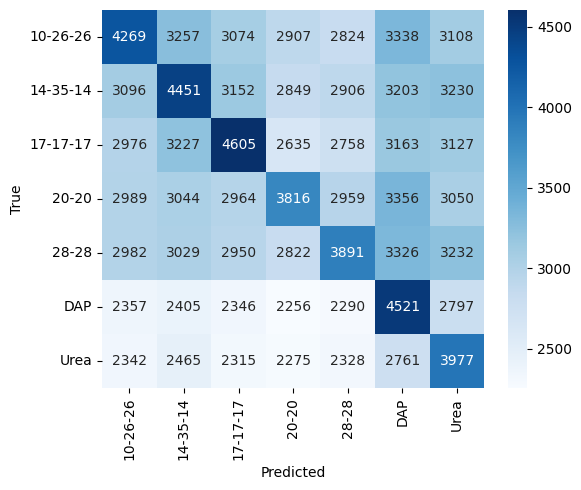

In [61]:
plot_confusion_matrix()

In [ ]:
def plot_eager_confusion_matrix(test_y = test_y, top3_probs = top3_probs):
    y_true = [np.int64(x) for x in test_y.to_list()]
    y_pred = []
    for idx, ans in enumerate(y_true):
        flag = 0
        for pans in top3_probs[idx]:
            if pans == ans:
                y_pred.append(pans)
                flag = 1
                break
        if flag == 0:
            y_pred.append(top3_probs[idx][0])
    cmat = confusion_matrix(y_true, y_pred)
    print("\nClassification report:")
    print(classification_report(y_true, y_pred, target_names = le.classes_))

    plt.figure(figsize = (6, 5))
    sns.heatmap(cmat, annot = True, fmt = 'd', xticklabels = le.classes_, yticklabels = le.classes_, cmap = "Blues")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.tight_layout()

    plt.show()


Classification report:
              precision    recall  f1-score   support

    10-26-26       0.54      0.51      0.52     22777
    14-35-14       0.53      0.52      0.53     22887
    17-17-17       0.54      0.52      0.53     22491
       20-20       0.54      0.50      0.52     22178
       28-28       0.54      0.51      0.53     22232
         DAP       0.47      0.54      0.50     18972
        Urea       0.47      0.53      0.49     18463

    accuracy                           0.52    150000
   macro avg       0.52      0.52      0.52    150000
weighted avg       0.52      0.52      0.52    150000



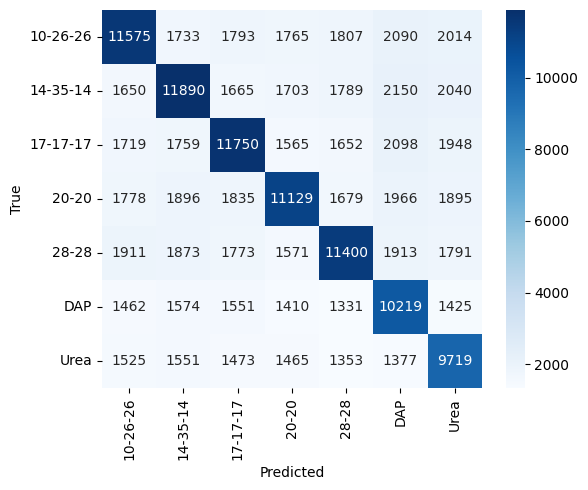

In [63]:
plot_eager_confusion_matrix()

In [67]:
## slight modification to the models based on understanding of arguments and intuitio.
n_models = {}
for t_x, (btx, bty) in btrain_splits.items():
    n_model_tx = XGBClassifier(
        objective="binary:logistic",
        n_estimators=1000,
        learning_rate=0.0225,
        max_depth=5,
        # colsample_bytree=0.6,
        # colsample_bylevel=0.8,
        # subsample=0.8,
        eval_metric="logloss"     # Optional but recommended for binary classification
    )

    n_model_tx.fit(btx, bty)
    n_models[t_x] = n_model_tx

In [72]:
n_predictions = {}
for t_x, n_model_tx in n_models.items():
    n_predictions[t_x] = n_model_tx.predict_proba(test_x)

In [73]:
ntop3_probs = interpret_predictions(predictions = n_predictions)

In [74]:
get_best_and_full_accuracy_xgboost(test_y, ntop3_probs)

First accuracy: 0.19
Score accuracy: 0.32



Classification report:
              precision    recall  f1-score   support

    10-26-26       0.54      0.48      0.51     22777
    14-35-14       0.54      0.50      0.52     22887
    17-17-17       0.53      0.51      0.52     22491
       20-20       0.53      0.49      0.51     22178
       28-28       0.52      0.50      0.51     22232
         DAP       0.44      0.53      0.48     18972
        Urea       0.44      0.53      0.48     18463

    accuracy                           0.50    150000
   macro avg       0.51      0.51      0.50    150000
weighted avg       0.51      0.50      0.51    150000



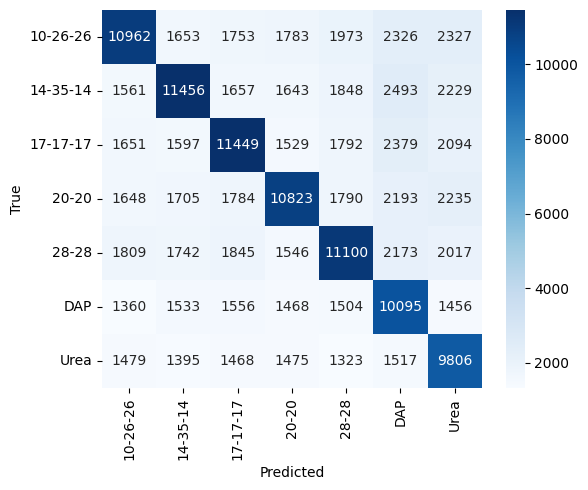

In [75]:
plot_eager_confusion_matrix(test_y = test_y, top3_probs = ntop3_probs)